In [45]:
import os
import pandas as pd
from pathlib import Path
from datasets import load_dataset, DownloadMode, DatasetDict
from collections import Counter
import re

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Download the dataset unless it already exists in \data

filepath = r'data'
destination_path = str(Path(filepath))

os.makedirs(destination_path, exist_ok=True)


dataset_emotion = load_dataset(
    "dair-ai/emotion", "unsplit", 
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS
)
print(dataset_emotion.shape)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 416809
    })
})


In [13]:
df = dataset_emotion['train'].to_pandas()
df.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [14]:
# Check for null values
print(df.isnull().sum())

text     0
label    0
dtype: int64


In [ ]:
# Get the label names for each emotion and add it to the df
label_names = dataset_emotion['train'].features['label'].names
df['emotion_str'] = df['label'].apply(lambda x: label_names[x])

print(label_names)

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [ ]:
# Counts of each emotion in the tweets
print(df['emotion_str'].value_counts())

emotion_str
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64


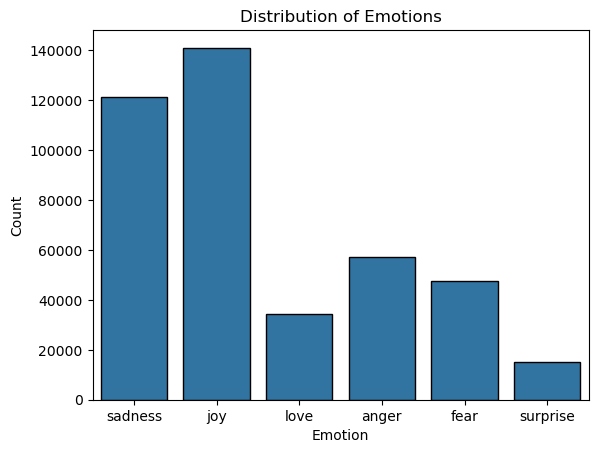

In [36]:
# A simple bar chart of the emotion distribution
sns.countplot(data=df, x='emotion_str', edgecolor='black')
plt.title("Distribution of Emotions")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [ ]:
# Adds a column for text length to the df
df['text_length'] = df['text'].apply(lambda x: len(x.split()))


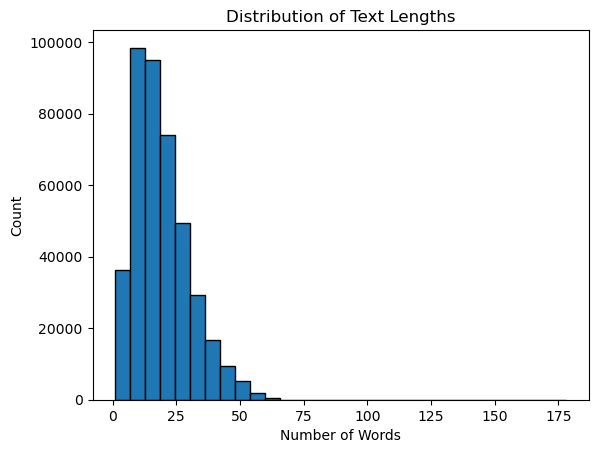

In [ ]:
# A histogram showing the word count distribution for all tweets
plt.figure()
plt.hist(df['text_length'], bins=30, edgecolor='black')
plt.title("Distribution of tweet length")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()


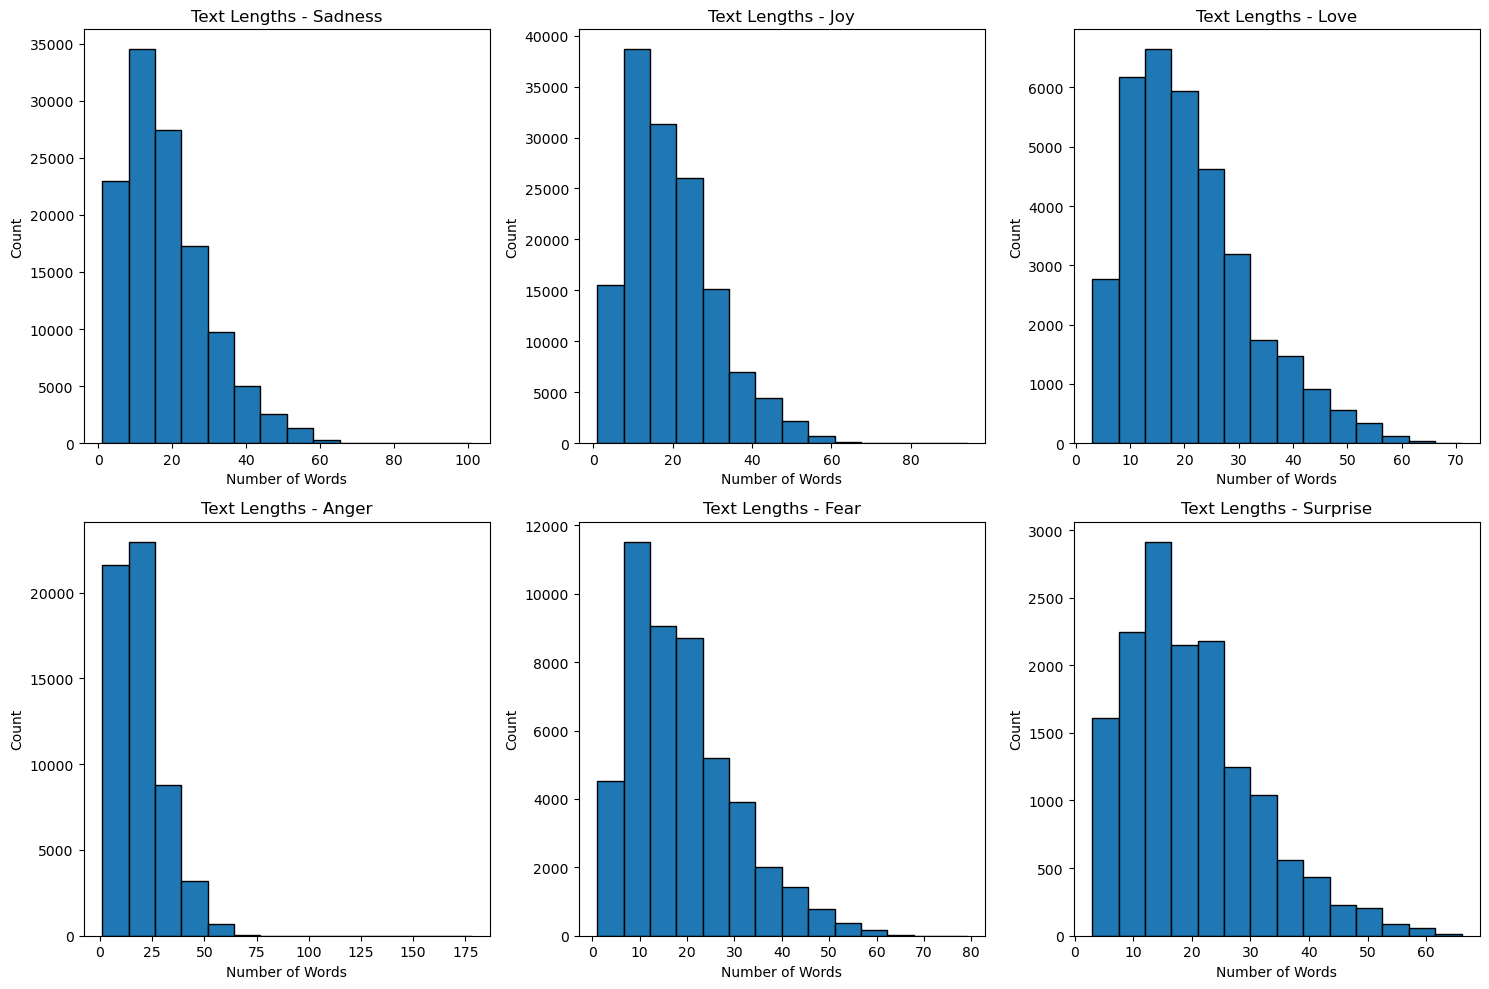

In [ ]:
# Histograms showing the indivudal word count distributions for all six emotions

emotions = df['emotion_str'].unique()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, emotion in enumerate(emotions):
    subset = df[df['emotion_str'] == emotion]
    axes[i].hist(subset['text_length'], bins=14, edgecolor='black')
    axes[i].set_title(f"Text Lengths - {emotion.capitalize()}")
    axes[i].set_xlabel("Number of Words")
    axes[i].set_ylabel("Count")


plt.tight_layout()
plt.show()


In [29]:
max_length = df['text_length'].max()
min_length = df['text_length'].min()
print(f"Longest text length: {max_length} words")
print(f"Shortest text length: {min_length} words")

Longest text length: 178 words
Shortest text length: 1 words


In [30]:
percentiles = df['text_length'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.98, 0.99])
print(percentiles)

0.25    11.0
0.50    17.0
0.75    25.0
0.90    35.0
0.95    41.0
0.98    48.0
0.99    52.0
Name: text_length, dtype: float64


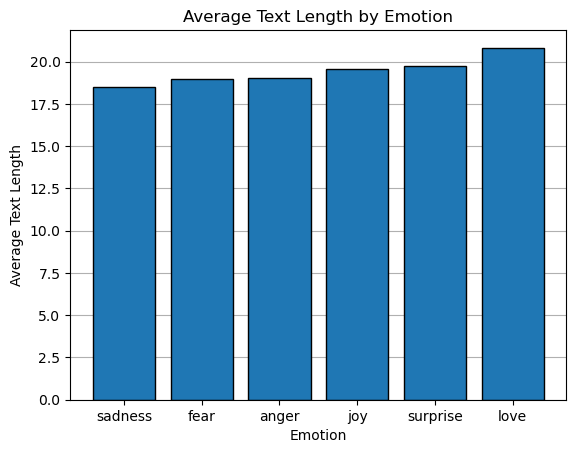

In [41]:
# Compute mean text length by emotion and sort
mean_lengths = df.groupby('emotion_str')['text_length'].mean().sort_values()

# Bar chart
plt.figure()
plt.bar(mean_lengths.index, mean_lengths.values, edgecolor='black', zorder=2)
plt.title("Average Text Length by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Average Text Length")
plt.grid(axis='y', zorder=1)
plt.show()


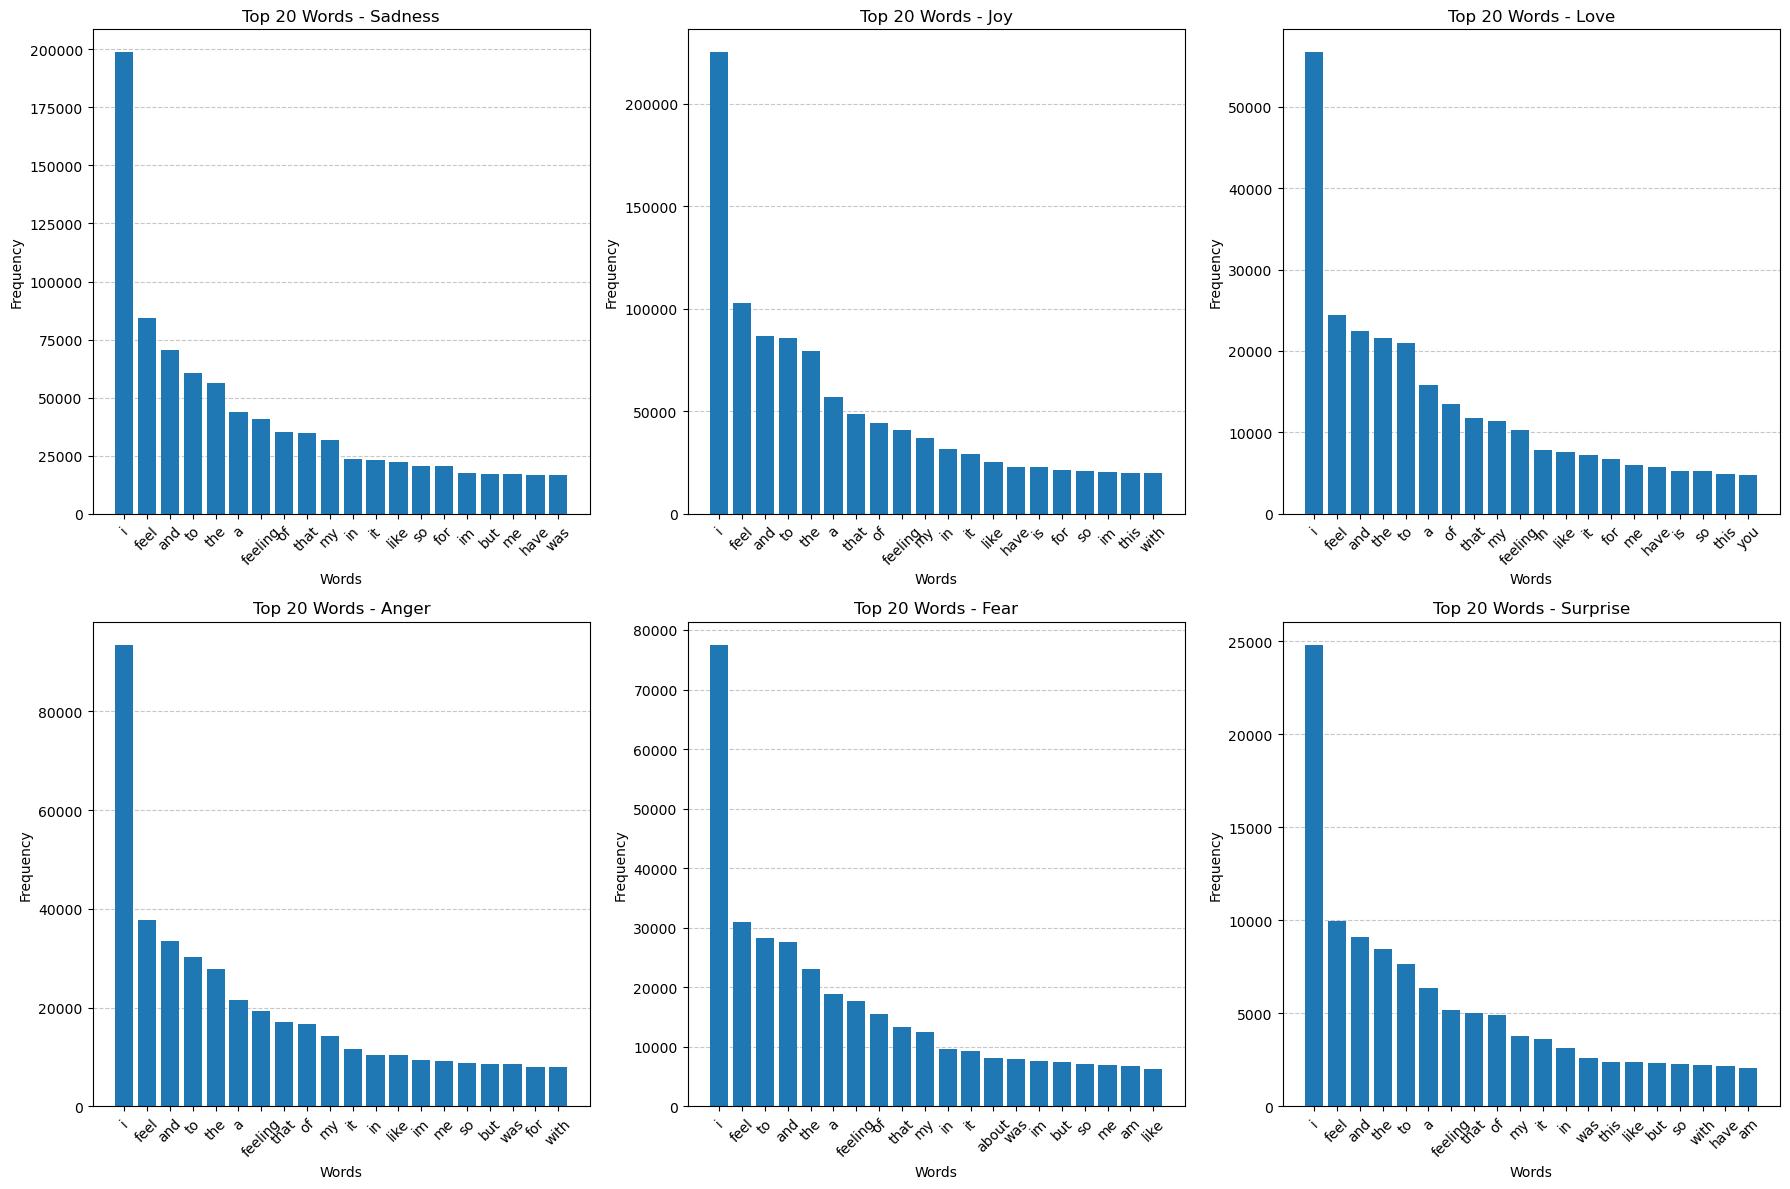

In [ ]:
# Create frequency plots showing how many times each word occurs in texts labeled with a given emotion
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 
axes = axes.flatten()


for i, emotion in enumerate(label_names):
    subset = df[df['emotion_str'] == emotion]

    all_words = []
    for txt in subset['text']:
        all_words.extend(txt.lower().split())

    # Get word frequency
    word_freq = Counter(all_words)
    most_common = word_freq.most_common(20) 

    # Prepare data for plotting
    if most_common:
        words, counts = zip(*most_common)

    # Plot the bar chart
    axes[i].bar(words, counts, zorder=2)
    axes[i].set_title(f"Top 20 Words - {emotion.capitalize()}")
    axes[i].set_xlabel("Words")
    axes[i].set_ylabel("Frequency")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

plt.tight_layout()
plt.show()


In [ ]:
# Find top 10 most common words for each emotion and their count

def simple_tokenizer(text):
    return re.findall(r"\w+", text.lower())

emotions = df['emotion_str'].unique()
for emotion in emotions:
    subset = df[df['emotion_str'] == emotion]['text']
    words = []
    for txt in subset:
        words.extend(simple_tokenizer(txt))
    top_words = Counter(words).most_common(10)
    print(f"Emotion: {emotion} --- Top 10 Words: {top_words}")


Emotion: sadness --- Top 10 Words: [('i', 198644), ('feel', 84184), ('and', 70589), ('to', 60555), ('the', 56262), ('a', 43643), ('feeling', 40849), ('of', 35094), ('that', 34696), ('my', 31895)]
Emotion: joy --- Top 10 Words: [('i', 225154), ('feel', 102709), ('and', 86957), ('to', 85554), ('the', 79354), ('a', 56767), ('that', 48872), ('of', 44480), ('feeling', 40953), ('my', 37210)]
Emotion: love --- Top 10 Words: [('i', 56675), ('feel', 24463), ('and', 22462), ('the', 21567), ('to', 20979), ('a', 15772), ('of', 13461), ('that', 11769), ('my', 11453), ('feeling', 10303)]
Emotion: anger --- Top 10 Words: [('i', 93430), ('feel', 37717), ('and', 33570), ('to', 30176), ('the', 27873), ('a', 21523), ('feeling', 19236), ('that', 17073), ('of', 16617), ('my', 14297)]
Emotion: fear --- Top 10 Words: [('i', 77495), ('feel', 30913), ('to', 28211), ('and', 27600), ('the', 23126), ('a', 18875), ('feeling', 17673), ('of', 15450), ('that', 13323), ('my', 12553)]
Emotion: surprise --- Top 10 Words

In [ ]:
# Find the number of duplicate words
dupe_counts = df['text'].value_counts()
duplicates = dupe_counts[dupe_counts > 1]
print("Number of duplicated texts:", len(duplicates))


Number of duplicated texts: 22817
